### Wstęp
Tematem laboratoriów jest kryptografia praktyczna. Będzie więc bardzo praktycznie. Na początek kilka niezbędnych informacji:
- XADES to format podpisu cyfrowego zapisywanego do pliku xml. Jest to także standard przyjęty przez UE. XADES wystepuje w kilku wersjach, nam wystarczy type **enveloped**. Strukturę podpisu można zobaczyć [tu](https://www.w3.org/TR/XAdES/).
- KSeF to inaczej Krajowy System e-Faktur. System ten udostępnia [testowe API](https://ksef-test.mf.gov.pl/). W testowym API wolno wykorzystywać certyfikaty typu self-signed. Generalnie KSeF jest system do którego się uploaduje faktury. Na jego podstawie możemy się jednak sporo nauczyć o praktycznych aspektach kryptografii.

Co nam będzie potrzebne:
- szyfr AES i RSA
- definicja podpisu cyfrowego
- podstawy http (post, get, put)
- znajomość formatów JSON, xsd i xml oraz serializację do tych formatów
- openssl do wygenerowania certyfikatów

Zaimportujmy najpierw niezbędne biblioteki.

In [1]:
!pip install xsdata[cli,lxml,soap]
!pip install google-colab-shell
!pip install pycryptodome
!pip install pem
!pip install signxml

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.9 MB 660.6 kB/s eta 0:00:06
    --------------------------------------- 0.1/3.9 MB 1.1 MB/s eta 0:00:04
   - -------------------------------------- 0.2/3.9 MB 1.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.3/3.9 MB 1.6 MB/s eta 0:00:03
   ---- ----------------------------------- 0.4/3.9 MB 1.7 MB/s eta 0:00:03
   ---- ----------------------------------- 0.4/3.9 MB 1.8 MB/s eta 0:00:02
   ---- ----------------------------------- 0.5/3.9 MB 1.5 MB/s eta 0:00:03
   ----- ---------------------------------- 0.6/3.9 MB 1.5 MB/s eta 0:00:03
   ------ --------------------------------- 0.6/3.9 MB 1.5 MB/s eta 0:00:03
   ------ --------------------------------- 0.7/3.9 MB 1.4 MB/s eta 0:00:03
   ------- -------------------------------- 0.7/3.9 MB 1.4 MB/s eta

### Generowanie klas

Przenieś pliki: initRequest.xsd oraz authRequest.xsd do folderu głównego w colabie. Wywołaj w poniższej konsoli polecenie "xsdata generate ./"

In [2]:
from google_colab_shell import getshell

getshell()
getshell(height=400)

ModuleNotFoundError: No module named 'google.colab'

Zaimportuj wygenerowane klasy:

In [ ]:
from generated import *
from generated.online.types.pkg_2021.pkg_10.pkg_01.pkg_0001.online_types import *
from generated.types.pkg_2021.pkg_10.pkg_01.pkg_0001.gtw_types import *

### Inicjalizacja szyfrów

KSeF daje możliwość wymiany materiału kryptograficznego przy nazwiązaniu sesji. Idea jest taka, że wysyłane faktury będziemy szyfrować własnym szyfrem AES. Ale musimy wpierw wysłać jakoś do systemu nasz klucz. Do tego posłuży klucz publiczny RSA.

Będziemy musieli wykonać następujące czynnosći:
1. Wygenerować klucz AES (32B) oraz wektor inicjalizujący IV (16B). Mogą to być po prostu losowe bajty wygenerowane z uzyciem get_random_bytes.
2. Przerzucić do projektu klucz publiczny RSA (publicKey.pem). Jest to plik ze [strony testowej KSeF](https://ksef-test.mf.gov.pl/) z zakładki "klucz publiczny środowiska testowego (PEM)".
3. Odczytać z tego pliku klucz publiczny RSA i użyć go do zaszyfrowania wygenerowanych kluczy AES.
4. Zakodować klucz i IV jako stringi Base64.

Uzupełnij brakujące fragmenty w kodzie poniżej. Dokumentacja do szyfrowania RSA jest [tutaj](https://pycryptodome.readthedocs.io/en/latest/src/cipher/pkcs1_v1_5.html).

In [ ]:
import pem
from Crypto.Random import get_random_bytes
import base64
from Crypto.Cipher import PKCS1_v1_5
from Crypto.PublicKey import RSA

# 32 random bytes
aes_key =

# 16 random bytes
aes_iv =

with open('publicKey.pem', 'rb') as f:
   certs = pem.parse(f.read())
print(certs[0].decoded_payload)

rsa_key =
print(rsa_key.public_key)
cipher =

# cipher the key
aes_key_ciphered =
aes_key_base64 =

# convert to base64 string
aes_iv_base64 =

print(aes_key_base64)
print(aes_iv_base64)


### Nawiązanie sesji

Aby rozpocząć połączenie wysyłamy JSON-a AuthorisationChallenge zgodnego ze specyfikacją zawartą w pliku KSeF-online.yaml. Będziemy się identyfikować NIPem. Możesz go zmienić, ale uwaga, bo nawet w środowisku testowym jest obecna walidacja NIPu. Jeżeli chcesz go zmienić, uzyj jakiegoś generatora.

In [ ]:
import json
import requests

a = {}
a["contextIdentifier"] = {"type": "onip", "identifier": "8363695362"}
y = json.dumps(a)
print(y)
headers = {"Content-Type": "application/json"}
r = requests.post(
    "https://ksef-test.mf.gov.pl/api/online/Session/AuthorisationChallenge",
    data=y,
    headers=headers,
)
c = json.loads(r.content)
print(c)

W odpowiedzi dostajemy również JSON-a z informacją o tym jaki numer sesji nam przydzielono (challenge). Sesja jednak nie jest jeszcze nawiązana, jedynie zaznaczyliśmy w systemie, że takową chcemy nawiązać. Teraz zrobi się nieco trudniej. Aby nawiązać sesję musimy wykonać następujące czynności:

1. Utworzyć całą strukturę obiektów InitSessionSignedRequest. Definicja tego obiektu znajduje się w pliku initRequest.xsd. Cała struktura tych xsd jest nieco złożona, ale nasz generator poradził sobie z tym dobrze.
2. Zserializować utworzony obiekt do pliku xml.
3. Wykorzystując openssl wygenerować certyfikat, który nam posłuzy do podpisu.
4. W oparciu o powyższy certyfikat podpisać xml-a podpisem XADES i dopiero ten plik wysłać.

Idźmy po kolei. Najpierw struktura obiektów. Uzupełnij poniższy kod tak, by był zgodny z poniższą strukturą:

$
{
  "InitSessionSignedRequest": {
    "Context": {
      "Challenge": "20240324-CR-9D789E2A75-5A15961BE8-0B",
      "Identifier": {
        "Identifier": 8363695362
      },
      "DocumentType": {
        "Service": "KSeF",
        "FormCode": {
          "SystemCode": "FA (2)",
          "SchemaVersion": "1-0E",
          "TargetNamespace": "http://ksef.mf.gov.pl/wzor/2021/08/05/08051",
          "Value": "FA"
        }
      },
      "Encryption": {
        "EncryptionKey": {
          "Encoding": "Base64",
          "Algorithm": "AES",
          "Size": 256,
          "Value": "s3rtDSVyUxotyDmOz1ZALvaQBrFyBhLVxzh8cOIPG65bKKMU7CdSoFc2U2TQSu4SF7uZnqx7u6NpWYCXD1siqRwrORY3qWREFHdFFZP6+Gd7jV/Y4n+3r3rMBz+n+naRfJ9JeMWzTIjJrCV13BymEuH90g/BbmeijlXj5910Az0Ju2zasdAXdL0hPQg+IB6xw0FGUh2OW3tZHzf4XhJNTEMxdQ72h0B5IdS/VHmjdzW+1NEQqrce0qSmAwxER8LjjCWY0wd+nOGJCmSrJHf3lz2AzfkNIffiaGVhK2sV42YfApqwJ1fcnNXMplQa5KVoiEufa9Ugu06a7Ll6va7SVA=="
        },
        "EncryptionInitializationVector": {
          "Encoding": "Base64",
          "Bytes": 16,
          "Value": "ABBH5/1l5BYZTCwAFMjkvw=="
        },
        "EncryptionAlgorithmKey": {
          "Algorithm": "RSA",
          "Mode": "ECB",
          "Padding": "PKCS#1"
        },
        "EncryptionAlgorithmData": {
          "Algorithm": "AES",
          "Mode": "CBC",
          "Padding": "PKCS#7"
        }
      },
      "Type": "SerialNumber"
    }
  }
}
$




Zauważ, że używamy wersji algorytmów RSA/ECB/PKCS1 oraz AES/CBC/PKCS7. Te ograniczenia wynikają z samego API. Klucz AES przesyłany jest jako Base64. Podobnie IV. Jedyne pola, gdzie można coś zmienić to EncryptionKey.value, EncryptionInitializationVector.value oraz identyfikator i challenge w kontekście. Reszta to stałe.

In [ ]:
a = InitSessionSignedRequest()

Teraz serializacja do xml-a. Ponieważ wykorzystaliśmy xsdata do serializacji z xsd, tu też musimy wykorzystać tę bibliotekę.Dodatkowo wykorzystuję bibliotekę xml.dom.minidom do ładnego sformatowania xml-a. W przeciwnym wypadku może nie przejść walidacji. Musisz otrzymać taką strukturę jak w pliku initWzor.xml. Wykorzystaj ten plik do stworzenia odpowiednich namespace-ów.

Przydatne linki: [serializator xsdata](https://xsdata.readthedocs.io/en/v20.4.1/reference/xsdata.formats.dataclass.serializers.html) oraz [biblioteka poprawiająca formatowanie - xml.minidom](https://docs.python.org/3/library/xml.dom.minidom.html)

In [ ]:
from xsdata.formats.dataclass.serializers import *
import xml.dom.minidom

ns_map = {}
#np. ns_map["nazwa_namespacea"] = "link"

serializer =
serialized =
parsedToString = xml.dom.minidom.
pretty_xml_as_string = parsedToString.
print(pretty_xml_as_string)

xml_file = open("init.xml", "w")
xml_file.write(pretty_xml_as_string)
xml_file.close()

Pora na certyfikat. Zgodnie ze [stroną testową](https://ksef-test.mf.gov.pl/):
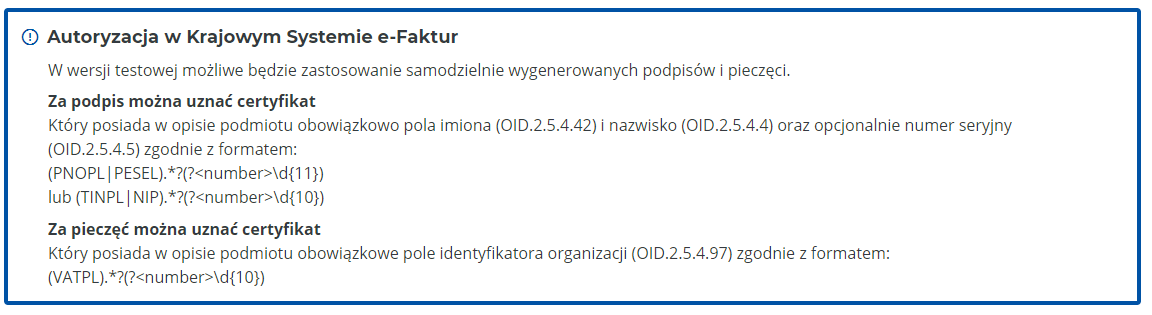

Czyli generując certyfikat x509 musimy pamiętać o dodaniu pól OID.2.5.4.42, OID.2.5.4.4 oraz OID.2.5.4.5 (numerem seryjnym będzie nasz NIP, string musi jednak być zgodny z regexem).

Do wygenerowania certyfikatu x509 użyj [openssl](https://www.openssl.org/docs/man1.1.1/man1/x509.html).

Wymagania:
- Klucz rsa powinien być 2048 bitowy.
- Przy generowaniu powinniśmy uzyć funkcji skrótu SHA-512.
- Dodanie odpowiednich OIDów. Możesz je dodać na podstawie [tej](https://oidref.com/2.5.4.5) strony. Zauważ, że możesz je wpisywać po komendzie -subj, np. -subj "/commonName=krypto".
- Niech certyfikat będzie ważny 1 dzień.

Ostatecznie będzie trzeba użyć następujących opcji: -x509, -sha512, -nodes, -subj, -days, -newkey, -keyout oraz -out. Certyfikat dodaj do pliku cert.pem, a klucz prywatny w pliku privkey.pem.

Openssla możesz użyć w terminalu utworzonym na początku notebooka. Podejrzeć certyfikat możesz komendą openssl x509 -in cert.pem -noout -text

Mając certyfikat możesz podpisać xml-a z wykorzystaniem biblioteki [signxml](https://xml-security.github.io/signxml/). Uzupełnij kod poniżej. Porównaj swojego xmla z plikiem wzorcowym (initSignedWzorzec.xml)

In [ ]:
from signxml import DigestAlgorithm
from signxml.xades import XAdESSigner
from lxml import etree

signer =

f = open("init.xml", "r")
doc = f.read()
f.close()

cert =
key =

root = etree.parse
et = etree.ElementTree
signed_doc = signer.sign
et.write

Mając podpisany dokument output.xml czas nawiązać sesję. Wzorzec zapytania jest dostępne w KSeF-online.yaml (/online/Session/InitSigned)

In [ ]:
f = open
doc =
f.close
r = requests.post
sesja = json.loads(r.content)
print(sesja)

In [ ]:
print(sesja["sessionToken"]["token"])

### Wysyłka faktury

Otrzymałeś/łaś fakturę faktura.xml. Wzorzec wysyłki jest dostępny w KSeF-online.yaml (/online/Invoice/Send). Przyglądnij się tej sktrukturze.
Wskazówki:
1. Dane binarne (sama faktura, skróty) są wysyłane w base64.
2. Liczone są dwa skróty: skrót z faktury niezawszyforwanej i z zaszyfrowanej.
3. Szyfrowanie odbywa się uzgodnionym kluczem AES.
4. Musisz dodać header SessionToken którego wartość należy wziąć z sesji.
5. Wysyłka faktury odbywa się PUTem, nie POSTem.
6. Przed szyfrowaniem AES musisz zastosować padding (dostępne w Crypto.Util.Padding). Wczytany plik musi być wyrównany do wielokrotności rozmiaru bloku AES (AES.block_size).

Uzupełnij poniższy kod.

In [ ]:
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import *

f = open
doc =
f.close()

cipher = AES.new
padded_data = pad
doc_encrypted =


a = {}
a["invoiceHash"] = {}

headers =
y = json.dumps(a)
print(y)
r = requests.put
reference = json.loads(r.content)
print(reference)

Jeżeli wszystko poszło prawidłowo, faktura jest już w systemie. Wyślij zapytanie na online/Invoice/Status/{elementReferenceNumber} aby zobaczyć czy faktura została przeprocesowana.

In [ ]:
headers =
r = requests.get
wynik = json.loads(r.content)
print(wynik)